In [1]:
import torch
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Example data (same as before)
X1 = np.linspace(-5, 5, 100)
X2 = np.linspace(-5, 5, 100)
X1, X2 = np.meshgrid(X1, X2)
X = np.vstack([X1.ravel(), X2.ravel()]).T
y = X1.ravel()**2 + X2.ravel()**2 + np.sin(X1.ravel() * X2.ravel())


In [3]:
# Scale the input data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to Torch tensors and move to GPU
X_scaled = torch.tensor(X_scaled, dtype=torch.float32).cuda()
y = torch.tensor(y, dtype=torch.float32).cuda()


In [4]:

# RBF Kernel function (on GPU)
def rbf_kernel(X1, X2, length_scale=1.0):
    pairwise_sq_dist = torch.sum(X1**2, dim=1).view(-1, 1) + torch.sum(X2**2, dim=1) - 2 * torch.matmul(X1, X2.T)
    return torch.exp(-pairwise_sq_dist / (2 * length_scale ** 2))


In [5]:

# Create the Gaussian Process Regression (GPR) model
class GPRModel(torch.nn.Module):
    def __init__(self, X, y, length_scale=1.0):
        super(GPRModel, self).__init__()
        self.X_train = X
        self.y_train = y
        self.length_scale = length_scale

    def forward(self, X_test):
        # Compute the RBF kernel between training and test points
        K = rbf_kernel(self.X_train, self.X_train, self.length_scale) + 1e-5 * torch.eye(self.X_train.size(0)).cuda()
        K_s = rbf_kernel(self.X_train, X_test, self.length_scale)
        K_ss = rbf_kernel(X_test, X_test, self.length_scale) + 1e-5 * torch.eye(X_test.size(0)).cuda()
        
        # Solve for the predictive mean and covariance
        K_inv = torch.inverse(K)
        mean = torch.matmul(torch.matmul(K_s.T, K_inv), self.y_train)
        var = K_ss - torch.matmul(torch.matmul(K_s.T, K_inv), K_s)
        return mean, var



In [6]:
# Train the model
gpr_model = GPRModel(X_scaled, y, length_scale=0.5)  # Adjust length_scale here
X_test = X_scaled  # Test on the same input space for simplicity

# Get predictions (mean and variance)
y_pred, _ = gpr_model(X_test)


In [7]:
# Calculate RMSE
rmse = torch.sqrt(F.mse_loss(y_pred, y))
print(f"Root Mean Squared Error (RMSE) using GPU-accelerated GPR: {rmse.item()}")


Root Mean Squared Error (RMSE) using GPU-accelerated GPR: 4072.807861328125


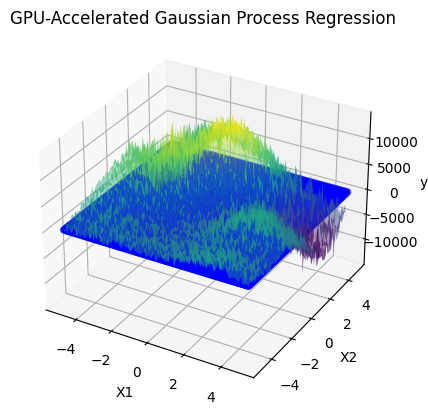

In [8]:
# Assuming X1, X2, y are already NumPy arrays
y_pred_cpu = y_pred.detach().cpu().numpy().reshape(X1.shape)

# Visualize results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1, X2, y.cpu().numpy(), color='blue', label='True values')
ax.plot_surface(X1, X2, y_pred_cpu, cmap='viridis', alpha=0.5)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('y')
ax.set_title("GPU-Accelerated Gaussian Process Regression")
plt.show()
